# Value at Risk (VaR)

$$Pr(X_{t}≤VaR_{α})=1−α$$

VaR measures the potential loss in value of a risky asset or portfolio over a defined period for a given confidence interval. For example, a one-day 95% VaR of $ 1 million means there is a 95% chance that the portfolio will not lose more than \$ 1 million in a day.

# Conditional Value at Risk (CVaR)

$$CVaR_{α}=E[X_{t}∣X_{t}≤VaR_{α}]$$

CVaR measures the average loss exceeding the VaR at a certain confidence level. It provides an estimate of the expected losses that occur beyond the VaR threshold.

In [18]:
import numpy as np
import matplotlib.pyplot as plt
import QuantLib as ql

In [ ]:
# Market and model parameters
spot_price = 100.0  # Initial spot price
strike_price = 130.0  # Strike price (set close to spot for sensitivity)
v0 = 0.1  # Initial variance (consider adjusting if unrealistic)
kappa = 0.2  # Rate of mean reversion
theta = 0.01  # Long-term variance mean
sigma = 0.1  # Volatility of volatility (adjust if too low)
rho = -0.7  # Correlation between the stock and volatility processes
risk_free_rate = 0.045  # Risk-free rate
dividend_yield = 0.01  # Dividend yield (adjusted for realism)

In [19]:
# QuantLib calendar and day count for scheduling
calendar = ql.UnitedStates(ql.UnitedStates.NYSE)
day_count = ql.Actual365Fixed()

start_date = ql.Date(1, 1, 2024)
exercise_date = start_date + ql.Period(1, ql.Years)
risk_free_ts = ql.YieldTermStructureHandle(ql.FlatForward(start_date, risk_free_rate, day_count))
dividend_yield_ts = ql.YieldTermStructureHandle(ql.FlatForward(start_date, dividend_yield, day_count))

# Define the initial stock price as a Quote object
s0 = ql.QuoteHandle(ql.SimpleQuote(spot_price))

# Setup the Heston process
heston_process = ql.HestonProcess(
    risk_free_ts,
    dividend_yield_ts,
    s0,
    v0,
    kappa,
    theta,
    sigma,
    rho)

# Create the Heston model
heston_model = ql.HestonModel(heston_process)

# Engine Setup: Using AnalyticHestonEngine
engine = ql.AnalyticHestonEngine(heston_model)

# Define an option to price
payoff = ql.PlainVanillaPayoff(ql.Option.Call, strike_price)
exercise = ql.EuropeanExercise(exercise_date)
option = ql.VanillaOption(payoff, exercise)

# Pricing the option using the engine
option.setPricingEngine(engine)
npv = option.NPV()
print("European Call Price: ", npv)

# Check the intrinsic value and time value
intrinsic_value = max(spot_price - strike_price, 0)
time_value = npv - intrinsic_value
print("Intrinsic Value: ", intrinsic_value)
print("Time Value: ", time_value)


European Call Price:  3.8380192433281484
Intrinsic Value:  0
Time Value:  3.8380192433281484


In [20]:
heston_process = ql.HestonProcess(risk_free_ts, dividend_yield_ts, s0, v0, kappa, theta, sigma, rho)

steps = 10
rng = "pseudorandom" # could use "lowdiscrepancy"
num_paths = 1_000_000
# Try initializing the engine with only essential parameters
try:
    mc_engine = ql.MCEuropeanHestonEngine(heston_process, rng, steps, requiredSamples=num_paths)
except Exception as e:
    print("Error initializing MCEuropeanHestonEngine: ", str(e))


# Set the engine and calculate the price
option.setPricingEngine(mc_engine)
price = option.NPV()
print("Price of the European Call Option: ", price)


Price of the European Call Option:  3.836308471170506


In [26]:
timestep = 365  # daily steps
year_fraction = day_count.yearFraction(start_date, exercise_date)
time_grid = ql.TimeGrid(year_fraction, timestep)

# Initialize the random number generator
dimension = heston_process.factors()
rng = ql.UniformRandomSequenceGenerator(dimension * timestep, ql.UniformRandomGenerator())
sequence_generator = ql.GaussianRandomSequenceGenerator(rng)
path_generator = ql.GaussianMultiPathGenerator(heston_process, list(time_grid), sequence_generator, False)


In [27]:
num_paths = 100_000
# Simulate the asset paths
end_prices = []
for i in range(num_paths):
    sample_path = path_generator.next()
    path = sample_path.value()
    end_price = path[0][-1]  # Last price of the stock path
    end_prices.append(end_price)

# Calculate the option payoffs
payoffs = [max(price - strike_price, 0) for price in end_prices]

# Sort the payoffs to compute VaR and CVaR
sorted_payoffs = sorted(payoffs)

# Calculate VaR at 95% confidence level
var_index = int(num_paths * 0.05)
var_95 = sorted_payoffs[var_index]

# Calculate CVaR at 95% confidence level
cvar_95 = sum(sorted_payoffs[:var_index]) / var_index

print(f"VaR (95%): {var_95}")
print(f"CVaR (95%): {cvar_95}")

VaR (95%): 0
CVaR (95%): 0.0


In [29]:
# Check if there are any non-zero payoffs
non_zero_payoffs = [p for p in payoffs if p > 0]
print("Number of non-zero payoffs:", len(non_zero_payoffs))

# Calculate VaR and CVaR with non-zero payoffs if available
if non_zero_payoffs:
    sorted_non_zero_payoffs = sorted(non_zero_payoffs)
    var_95 = sorted_non_zero_payoffs[int(len(sorted_non_zero_payoffs) * 0.05)]
    cvar_95 = sum(sorted_non_zero_payoffs[:int(len(sorted_non_zero_payoffs) * 0.05)]) / int(len(sorted_non_zero_payoffs) * 0.05)
    print(f"VaR (95%): {var_95}")
    print(f"CVaR (95%): {cvar_95}")
else:
    print("No non-zero payoffs available for VaR and CVaR calculation.")


Number of non-zero payoffs: 18928
VaR (95%): 1.2326333618668173
CVaR (95%): 0.5901871586032253


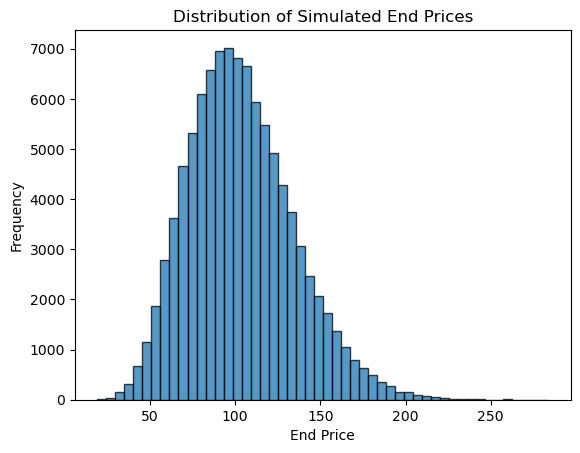

In [34]:
# Plotting the distribution of end prices
plt.hist(end_prices, edgecolor='black', bins=50, alpha=0.75)
plt.title('Distribution of Simulated End Prices')
plt.xlabel('End Price')
plt.ylabel('Frequency')
plt.show()